In [5]:
from data_preprocess import *
from train_and_test import *
import os
import yaml
from config_loader import *
import pandas as pd

/var/folders/6x/w_phznyd4830j7jb8y12rhrc0000gn/T/ipykernel_34235/2756201873.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

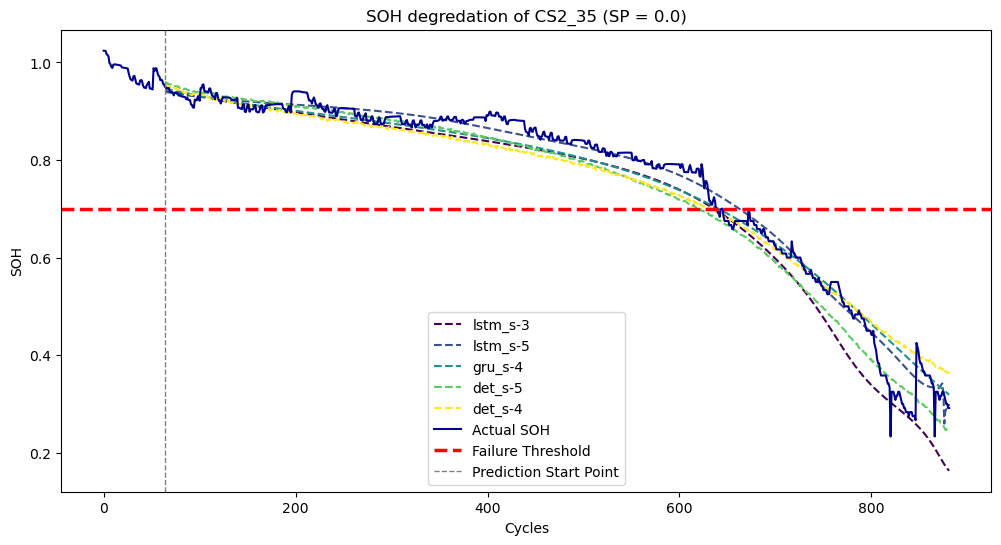

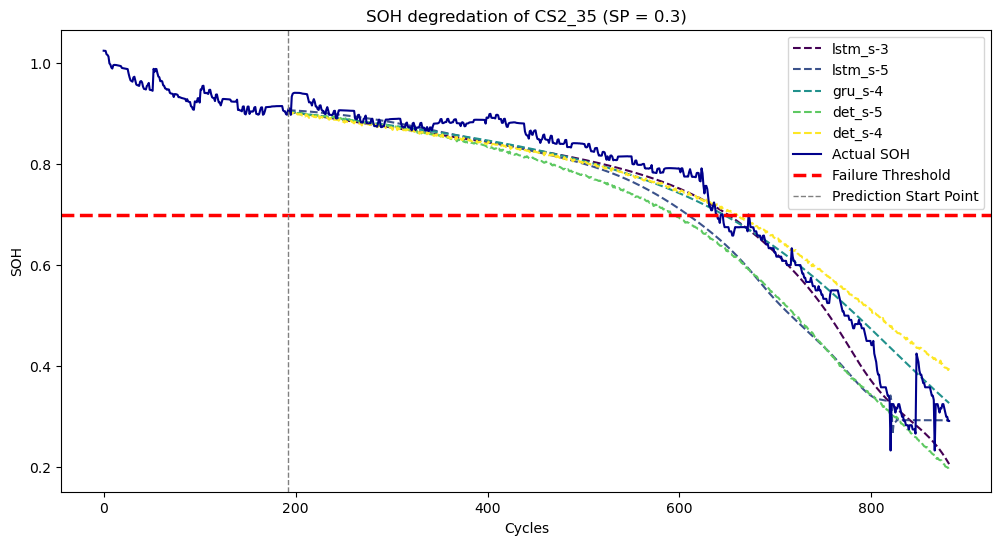

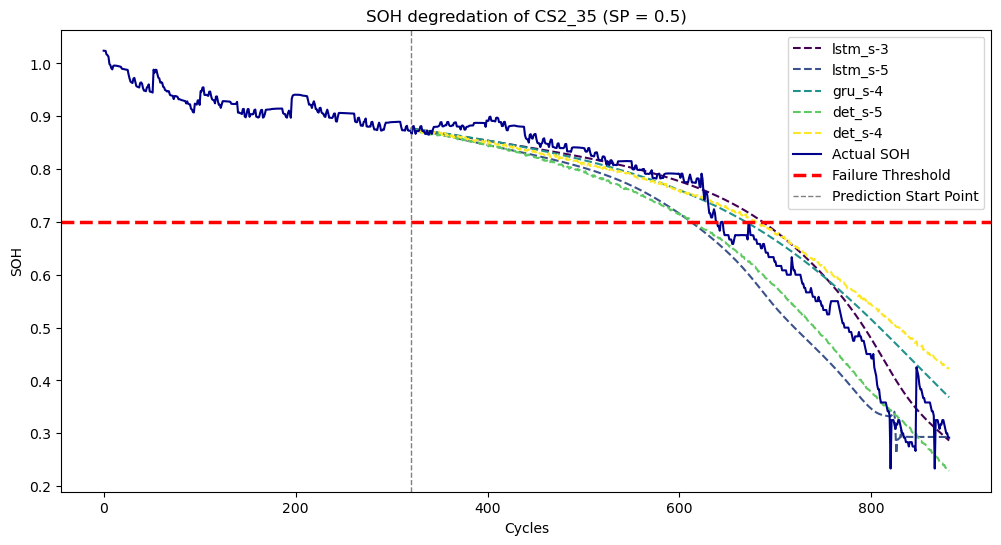

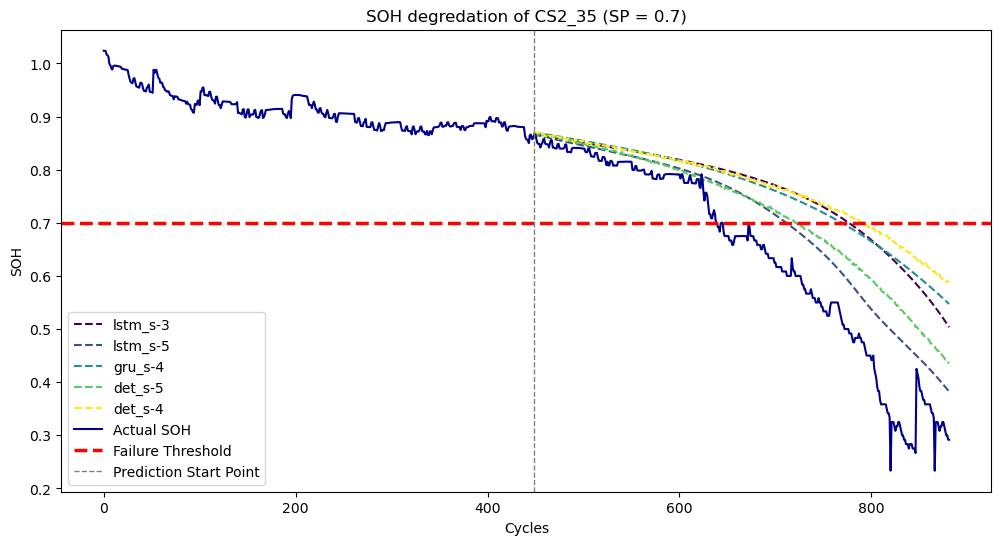

,SP,Model,RE,RMSE,MAE
0,0.0,det_s-4,0.011,0.0425,0.0327
1,0.0,det_s-5,0.030,0.0383,0.0316
2,0.0,gru_s-4,0.002,0.0334,0.0240
3,0.0,lstm_s-3,0.005,0.0478,0.0359
4,0.0,lstm_s-5,0.036,0.0245,0.0164
5,0.3,det_s-4,0.028,0.0520,0.0390
6,0.3,det_s-5,0.072,0.0686,0.0584
7,0.3,gru_s-4,0.009,0.0370,0.0273
8,0.3,lstm_s-3,0.017,0.0368,0.0284
9,0.3,lstm_s-5,0.048,0.0592,0.0473


In [9]:
dir = model_save_dir
test_models = {
    'lstm': [3, 5],
    'gru': [4],
    'det': [4, 5]
}

# 画图：指定模型文件范围，不同预测起始点（0.0、0.3、0.5、0.7）
# 1. 初始化结果字典
'''
results:
    - key: sp
        - subkey: model_key
        - val: pred_seq
metrics:
    - key: sp
        - subkey: model_key
        - val: [re, rmse, mae]
'''
results, metrics = {}, {}
for sp in start_points:
    results[sp] = {}
    metrics[sp] = {}

# 2. 获取数据
norm_data, failure_time = read_and_norm(data_path, rated_capacity, failure_threshold)
_, actual_seq = split_data(norm_data, test_bat)

for filename in os.listdir(dir):
    exp_num, model_name, s_num = parse_model_filename(filename)

    if s_num in test_models[model_name]:
        # 3. 加载模型
        model_config = models_config[model_name]
        model_path = os.path.join(dir, filename)
        model = get_model(model_config, device)
        model.load_state_dict(torch.load(model_path, map_location=device))
            
        # 4. 预测：生成预测曲线、计算评价指标
        for sp in start_points:
            pred_seq = predict(model_config, model, sp, actual_seq, seq_length, failure_threshold, device)
            model_key = f'{model_name}_s-{s_num}'
            results[sp][model_key] = pred_seq

            re, rmse, mae = cal_metrics(actual_seq, pred_seq, sp, seq_length, failure_threshold)
            metrics[sp][model_key] = [re, rmse, mae]


# 5. 画图、打印评价指标（一个sp对应一张图）
for sp, pred_seqs in results.items():
    plot(actual_seq, pred_seqs, sp, failure_threshold, seq_length, test_bat)

metric_results = []
for sp, sub_dict in metrics.items():
    for model_key, metric_vals in sub_dict.items():
        metric_results.append({
            'SP': sp,
            'Model': model_key,
            'RE': round(metric_vals[0], 3),
            'RMSE': round(metric_vals[1], 4),
            'MAE': round(metric_vals[2], 4)
        })
        # print(f'SP: {sp}, Model: {model_key}, RE: {metric_vals[0]:.3f}, RMSE: {metric_vals[1]:.4f}, MAE: {metric_vals[2]:.4f}')
metrics_df = pd.DataFrame(metric_results).sort_values(by=['SP', 'Model']).reset_index(drop=True)
metrics_df

In [8]:
metrics_df = metrics_df.sort_values(by=['SP', 'Model'])
metrics_df = metrics_df.reset_index(drop=True)
metrics_df


,SP,Model,RE,RMSE,MAE
0,0.0,det_s-4,0.008,0.0424,0.0324
1,0.0,det_s-5,0.023,0.0333,0.0276
2,0.0,gru_s-4,0.002,0.0334,0.0240
3,0.0,lstm_s-3,0.005,0.0478,0.0359
4,0.0,lstm_s-5,0.036,0.0245,0.0164
5,0.3,det_s-4,0.006,0.0469,0.0357
6,0.3,det_s-5,0.083,0.0751,0.0641
7,0.3,gru_s-4,0.009,0.0370,0.0273
8,0.3,lstm_s-3,0.017,0.0368,0.0284
9,0.3,lstm_s-5,0.048,0.0592,0.0473
